Finding basic level categoies
================

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as pltColors
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from scipy.spatial.distance import cosine
import csv
from collections import Counter, defaultdict
from sklearn.preprocessing import normalize
from numpy.linalg import norm
from numpy.linalg import pinv
from scipy.stats import linregress
import scipy.io as sio
from math import log
from scipy.stats import entropy
from sklearn.preprocessing import scale
from scipy.stats import linregress
log2 = lambda x: log(x, 2)
lstDiv = lambda x, y: [a / b for a, b in zip(x, y)]

In [18]:
# Load files
inputFile = 'data/cat_desc_wn.csv'
headers = None
descCnt = Counter()
catCnt = Counter()
descCatCnt = defaultdict(Counter)
with open(inputFile) as fin:
    r = csv.reader(fin)
    for row in r:
        if headers is None:
            headers = row
            print headers
        else:
            cat, desc, cnt = row
            cat = int(cat) - 1
            cnt = int(cnt)
            descCnt[desc] += cnt
            catCnt[cat] += cnt
            descCatCnt[desc][cat] += cnt

catNameFile = 'data/categoryKey.csv'
catName = {}
with open(catNameFile) as fin:
    r = csv.reader(fin)
    for row in r:
        catName[int(row[0]) - 1] = row[1]

print range(len(catName)) == catName.keys() and range(len(catName)) == catCnt.keys()

simMtxGTFile = 'data/largeSimMatrix.mat'
simMtxGT = sio.loadmat(simMtxGTFile)['largeSimMatrix']
print simMtxGT.shape

wordFreqFile = 'data/MsrWordLog10Freq.csv'
wordFreqHeader = None
wordFreq = {}
with open(wordFreqFile) as fin:
    r = csv.reader(fin)
    for row in r:
        if wordFreqHeader is None:
            wordFreqHeader = row
            print wordFreqHeader
        else:
            desc, logFreq = row
            logFreq = float(logFreq)
            wordFreq[desc] = logFreq

['category_id', 'description', 'count']
True
(1055, 1055)
['description', 'log10JointProb']


In [19]:
# # Remove pular words in dictionary
# tmpDict = Counter()
# for k, v in wordFreq.iteritems():
#     if k[-1] == 's' and wordFreq[k[:-1]] > v:
#         tmpDict[k[:-1]] += v
#     else:
#         tmpDict[k] += v
# wordFreq = tmpDict

In [38]:
# filter descriptions
threshold = 100
descList = [d for d, c in descCnt.most_common() if c >= threshold]
descId = {d:i for i, d in enumerate(descList)}
descFreq = [float(descCnt[d]) for d in descList]
descWordCnt = [len(w.split()) for w in descList]
print len(descList), len(descCnt)
print sum(descCnt[d] for d in descList), sum(descCnt.itervalues())
print descFreq[:10]
filterWordNum = lambda lst, k: [a for a, b in zip(lst, descWordCnt) if b == k]

1204 3058
4413069 4477386
[228830.0, 209892.0, 199302.0, 171715.0, 150931.0, 123176.0, 118045.0, 114949.0, 103442.0, 96420.0]


In [39]:
# Effectiveness score
descDistMtx = np.zeros((len(descList), len(catName)))
for i, desc in enumerate(descList):
    sumOccur = float(descCnt[desc])
    for c, v in descCatCnt[desc].iteritems():
        descDistMtx[i, c] = v / sumOccur
tmpMtx = descDistMtx.dot(simMtxGT)
s1_1 = []
for i, desc in enumerate(descList):
    s1_1.append(-log2(np.dot(tmpMtx[i], descDistMtx[i])))
s1_1 = scale(s1_1)

s1_2 = []
for i, desc in enumerate(descList):
    s1_2.append(entropy(descDistMtx[i]))
s1_2 = scale(s1_2)

In [40]:
# Cost score
s2_1 = []
for desc in descList:
    s2_1.append(float(len(desc)))
s2_1 = scale(s2_1)

s2_2 = []
charSet = set('aeiouy')
for desc in descList:
    s2_2.append(float(len([c for c in desc if c in charSet])))
s2_2 = scale(s2_2)

s2_3 = []
for desc in descList:
    s2_3.append(-wordFreq[desc])
s2_3 = scale(s2_3)

s2_4 = []
for desc in descList:
    s2_4.append(log2(sum(descCnt.itervalues())) - log2(descCnt[desc]))
s2_4 = scale(s2_4)

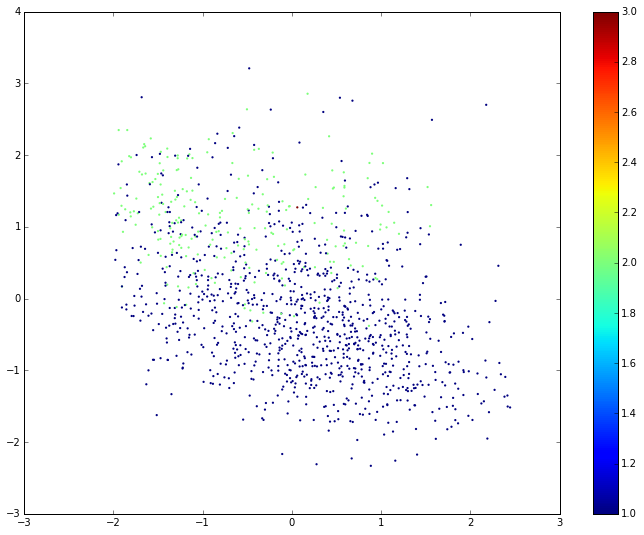

In [41]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(1,1,1)
scat = ax.scatter(s1_1, s2_3, c=[len(w.split('_')) for w in descList], s=5, edgecolor='')# , norm=pltColors.LogNorm())
cbar = fig.colorbar(scat, ax=ax)
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

In [42]:
print sorted(descList, key=lambda w: s1_1[descId[w]], reverse=False)[:10]
print sorted(descList, key=lambda w: s1_1[descId[w]], reverse=True)[:10]

['revolving_door', 'carousel', 'laundromat', 'raft', 'confessional', 'bullring', 'rope_bridge', 'martial_art', 'fire_escape', 'tree_farm']
['men', 'man', 'person', 'picture', 'image', 'none', 'unknown', 'viewpoint', 'peoples', 'human']


In [43]:
print sorted(descList, key=lambda w: s1_2[descId[w]], reverse=False)[:10]
print sorted(descList, key=lambda w: s1_2[descId[w]], reverse=True)[:10]

['sandbox', 'revolving_door', 'nursing_home', 'limousine', 'beehive', 'confessional', 'laundromat', 'bowling_alley', 'raft', 'carousel']
['place', 'peoples', 'hall', 'building', 'men', 'wall', 'house', 'company', 'room', 'person']


In [45]:
print sorted(descList, key=lambda w: s2_3[descId[w]], reverse=False)[:10]
print sorted(descList, key=lambda w: s2_3[descId[w]], reverse=True)[:10]

['home', 'book', 'sign', 'view', 'business', 'see', 'post', 'top', 'people', 'school']
['aerogram', 'cow_barn', 'poolroom', 'frontward', 'woodlouse', 'mechanist', 'slum_area', 'bookstall', 'teashop', 'maranta']


In [46]:
slope, intercept, r_value, p_value, std_err = linregress(s1_2, s2_3)
print slope, r_value**2, std_err
evalScore = [a * (-slope) + b for a, b in zip(s1_2, s2_3)]
print sorted(descList, key=lambda w: evalScore[descId[w]], reverse=False)[:10]
print sorted(descList, key=lambda w: evalScore[descId[w]], reverse=True)[:10]

-0.441600895183 0.195011350626 0.0258787112312
['power', 'book', 'sign', 'post', 'body', 'fashion', 'shoes', 'left', 'business', 'phone']
['frontward', 'mechanist', 'woodlouse', 'aerogram', 'maranta', 'cow_barn', 'bookstall', 'wash_room', 'teashop', 'palas']


In [47]:
slope, intercept, r_value, p_value, std_err = linregress(s1_1, s2_3)
print slope, r_value**2, std_err
evalScore = [a * (-slope) + b for a, b in zip(s1_1, s2_3)]
print sorted(descList, key=lambda w: evalScore[descId[w]], reverse=False)[:50]
print sorted(descList, key=lambda w: evalScore[descId[w]], reverse=True)[:50]

-0.438345866715 0.192147098866 0.0259247102191
['power', 'see', 'book', 'home', 'view', 'big', 'shoes', 'fashion', 'phone', 'estate', 'sign', 'ball', 'press', 'model', 'city', 'food', 'post', 'university', 'stop', 'left', 'medical', 'cock', 'football', 'business', 'beach', 'island', 'golf', 'body', 'massage', 'shower', 'tv', 'deep', 'music', 'funny', 'telephone', 'jewelry', 'guitar', 'wind', 'dog', 'water', 'store', 'training', 'school', 'pump', 'running', 'car', 'well', 'fire', 'fan', 'cat']
['mechanist', 'maranta', 'woodlouse', 'frontward', 'aerogram', 'cow_barn', 'teashop', 'bookstall', 'wash_room', 'slum_area', 'playing_area', 'wall_painting', 'military_man', 'godown', 'rest_area', 'eatable', 'palas', 'pigsty', 'glasshouse', 'poolroom', 'assembly_hall', 'storeroom', 'dustbin', 'paddy_field', 'study_hall', 'workroom', 'drawing_room', 'beauty_parlor', 'toyshop', 'ropeway', 'cultivated_land', 'guestroom', 'curium', 'ticket_booth', 'musial', 'cattle_farm', 'oast', 'water_plant', 'circu

In [29]:
slope, intercept, r_value, p_value, std_err = linregress(s1_2, s2_3)
print slope, r_value**2, std_err

-0.418737891116 0.175341421456 0.0164270816429


In [15]:
slope, intercept, r_value, p_value, std_err = linregress(filterWordNum(s1_2, 1), filterWordNum(s2_3, 1))
print slope, r_value**2, std_err

-0.441600895183 0.195011350626 0.0258787112312


In [16]:
slope, intercept, r_value, p_value, std_err = linregress(s1_1, s1_2)
print slope, r_value**2, std_err

0.869364217099 0.755794141972 0.014253640631
